In [66]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from tqdm import tqdm
from collections import defaultdict
import requests
import ipyparallel as ipp
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import math
import time
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.metrics import r2_score
import logging
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

In [2]:
def fetch_counts_for_year(year):
    counts_for_year = defaultdict(int)
    offset = 0
    limit = 10000
    while True:
        url = (
            f"https://data.cnra.ca.gov/api/3/action/datastore_search?"
            f"resource_id=bfa9f262-24a1-45bd-8dc8-138bc8107266"
            f"&q={year}&limit={limit}&offset={offset}"
        )
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            records = data['result']['records']
            for record in records:
                site_code = record.get('site_code')
                if record.get('gse_gwe') is None:
                    continue
                if site_code:
                    counts_for_year[site_code] += 1
            if len(records) < limit:
                break
            offset += limit
        else:
            print(f"Failed to fetch data for year {year}")
            break
    return counts_for_year

rc = ipp.Client()
dview = rc[:]

with dview.sync_imports():
    import requests
    from collections import defaultdict

dview.push({'fetch_counts_for_year': fetch_counts_for_year})

years = list(range(2000, 2025))

async_results = dview.map_async(fetch_counts_for_year, years)
results = async_results.get()

counts = defaultdict(lambda: defaultdict(int))
for year, year_counts in zip(years, results):
    for site_code, count in year_counts.items():
        counts[site_code][year] = count

obs_df = pd.DataFrame.from_dict(counts, orient='index')
obs_df = obs_df.fillna(0).astype(int)
obs_df.columns = [f'observations_{year}' for year in obs_df.columns]
obs_df = obs_df.reset_index().rename(columns={'index': 'site_code'})

importing requests on engine(s)
importing defaultdict from collections on engine(s)


In [3]:
obs_df

,site_code,observations_2000,observations_2004,observations_2020,observations_2021,observations_2022,observations_2023,observations_2024,observations_2001,observations_2002,...,observations_2012,observations_2013,observations_2014,observations_2015,observations_2017,observations_2018,observations_2003,observations_2008,observations_2016,observations_2019
0,384444N1211868W001,2,1,1,2,2,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,365142N1194085W001,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,365275N1193788W001,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,365153N1192731W001,1,0,0,0,0,0,0,1,1,...,3,1,2,1,2,1,0,0,0,0
4,365194N1179184W001,265,366,366,365,255,0,0,218,312,...,0,0,0,275,365,193,358,203,366,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21701,362999N1200484W001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
21702,361232N1201160W002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
21703,364080N1193363W002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
21704,361671N1200227W002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
SGMA = "../data/GWBasins.shp"
gdf = gpd.read_file(SGMA)
gdf.set_crs(epsg=3857, inplace=True)
gdf.set_index('OBJECTID', inplace=True)
gdf['Basin_Prefix'] = gdf['Basin_Numb'].str.split('-').str[0].astype(int)
central = gdf[gdf.Basin_Numb.str.startswith("5")].copy()
stations = pd.read_csv("../data/stations_depth_geology.csv", index_col="_id")
geometry = [Point(xy) for xy in zip(stations['longitude'], stations['latitude'])]
stations_geo = gpd.GeoDataFrame(stations, geometry=geometry, crs="EPSG:4326")
stations_geo = stations_geo.to_crs(epsg=3857)
joined_gdf = gpd.sjoin(stations_geo, central, how="left", predicate="within")
stations_geo["Basin_Numb"] = joined_gdf["Basin_Numb"]
stations_geo["Basin_Subb"] = joined_gdf["Basin_Subb"]
stations_geo["RO"] = joined_gdf["Region_Off"]
central_stations = stations_geo[~stations_geo.Basin_Numb.isna()].copy()
central_obs = obs_df[obs_df.site_code.isin(set(central_stations.site_code))].copy()

In [5]:
observation_columns = [col for col in obs_df.columns if col.startswith('observations_')]
central_ov5 = obs_df[obs_df[observation_columns].ge(5).all(axis=1)]

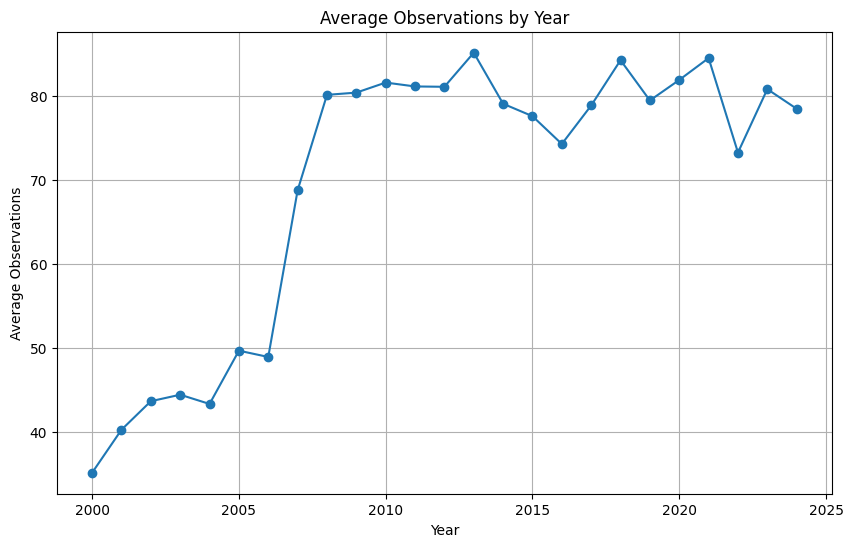

In [8]:
average_observations = central_ov5[observation_columns].mean()
years = [int(col.split('_')[1]) for col in observation_columns]
average_series = pd.Series(data=average_observations.values, index=years).sort_index()

plt.figure(figsize=(10, 6))
plt.plot(average_series.index, average_series.values, marker='o', linestyle='-')
plt.title('Average Observations by Year')
plt.xlabel('Year')
plt.ylabel('Average Observations')
plt.grid(True)
plt.show()

From this chart I have decided to take data from 2008 onwards.

In [9]:
columns_to_keep = ['site_code'] + [
    col for col in central_ov5.columns 
    if col.startswith('observations_') and int(col.split('_')[1]) >= 2008
]

central_ov5 = central_ov5[columns_to_keep]

In [10]:
def fetch_all_records(site_code, year):
    all_records = []
    offset = 0
    limit = 1000
    while True:
        url = (
            f"https://data.cnra.ca.gov/api/3/action/datastore_search?"
            f"resource_id=bfa9f262-24a1-45bd-8dc8-138bc8107266"
            f"&q={site_code} {year}&limit={limit}&offset={offset}"
        )
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            records = data['result']['records']
            all_records.extend(records)
            if len(records) < limit:
                break
            offset += limit
        else:
            print(f"Failed to fetch data for {site_code} in {year}")
            break
    return all_records

def get_readings_for_site(site_code, years):
    all_readings = []
    for year in years:
        records = fetch_all_records(site_code, year)
        for record in records:
            reading = {
                'site_code': record.get('site_code'),
                'msmt_date': record.get('msmt_date'),
                'wlm_rpe': record.get('wlm_rpe'),
                'wlm_gse': record.get('wlm_gse'),
                'gwe': record.get('gwe')
            }
            all_readings.append(reading)
    return pd.DataFrame(all_readings)

In [64]:
def compute_prophet_interpolation_error(site_code):
    years = list(range(2008, 2025))
    df_readings = get_readings_for_site(site_code, years)
    if df_readings.empty:
        return None
    
    df_readings['msmt_date'] = pd.to_datetime(df_readings['msmt_date'], errors='coerce').dt.normalize()
    df_readings = df_readings.dropna(subset=['msmt_date'])
    df_readings = df_readings.sort_values('msmt_date')
    df_readings = df_readings.dropna(subset=['gwe'])
    if df_readings.empty:
        return None
    
    prophet_df = df_readings[['msmt_date', 'gwe']].rename(columns={'msmt_date': 'ds', 'gwe': 'y'})
    prophet_df = prophet_df.sort_values('ds')
    
    if len(prophet_df) < 5:
        return None
    
    try:
        model = Prophet(**prophet_params)
        model.fit(prophet_df)
        
        df_cv = cross_validation(
            model=model,
            horizon='90 days',    # how far into the future each forecast goes
            period='90 days',     # spacing between cutoff dates
            initial='912 days'    # how much history in each training segment
        )
        
        df_perf = performance_metrics(df_cv)
        r2 = r2_score(df_cv['y'], df_cv['yhat'])
        base_metrics = df_perf[['rmse', 'mae', 'mape']].mean().to_dict()
        mean_y = df_cv['y'].mean()

        naive_rmse = np.sqrt(np.mean(np.diff(df_cv['y'])**2))
        naive_mae = np.mean(np.abs(np.diff(df_cv['y'])))
        
        rmse_scaled = base_metrics['rmse'] / naive_rmse
        mae_scaled  = base_metrics['mae']  / naive_mae
        metrics_of_interest = {
            'rmse': base_metrics['rmse'],
            'mae': base_metrics['mae'],
            'mape': base_metrics['mape'],
            'r2': r2,
            'rmse_scaled': rmse_scaled,
            'mae_scaled': mae_scaled
        }
        
        return metrics_of_interest

    except Exception as e:
        print(f"Error fitting/cross-validating model for site {site_code}: {e}")
        return None

In [79]:
prophet_params = {
    'changepoint_prior_scale': 0.01,
    'seasonality_prior_scale': 0.1
}

rc = ipp.Client()
dview = rc[:]

dview.push({
    'fetch_all_records': fetch_all_records,
    'get_readings_for_site': get_readings_for_site,
    'compute_prophet_interpolation_error': compute_prophet_interpolation_error,
    'prophet_params': prophet_params
})

dview.execute("""
import pandas as pd
import numpy as np
import requests
import math
from sklearn.metrics import r2_score
try:
    from prophet import Prophet
    from prophet.diagnostics import cross_validation, performance_metrics
except ImportError:
    from fbprophet import Prophet
    from fbprophet.diagnostics import cross_validation, performance_metrics
""")

site_codes = central_ov5['site_code'].tolist()
ar = dview.map_async(compute_prophet_interpolation_error, site_codes)

with tqdm(total=len(site_codes), desc="Completed wells") as pbar:
    last_progress = 0
    while not ar.ready():
        current_progress = ar.progress
        pbar.update(current_progress - last_progress)
        last_progress = current_progress
        time.sleep(1)
    current_progress = ar.progress
    pbar.update(current_progress - last_progress)

results = ar.get()

rmse_vals = []
mae_vals = []
mape_vals = []
r2_vals = []
rmse_scaled_vals = []
mae_scaled_vals = []

for metrics_dict in results:
    if metrics_dict is None:
        rmse_vals.append(None)
        mae_vals.append(None)
        mape_vals.append(None)
        r2_vals.append(None)
        rmse_scaled_vals.append(None)
        mae_scaled_vals.append(None)
    else:
        rmse_vals.append(metrics_dict.get('rmse', None))
        mae_vals.append(metrics_dict.get('mae', None))
        mape_vals.append(metrics_dict.get('mape', None))
        r2_vals.append(metrics_dict.get('r2', None))
        rmse_scaled_vals.append(metrics_dict.get('rmse_scaled', None))
        mae_scaled_vals.append(metrics_dict.get('mae_scaled', None))

central_ov5['prophet_interp_rmse'] = rmse_vals
central_ov5['prophet_interp_mae'] = mae_vals
central_ov5['prophet_interp_mape'] = mape_vals
central_ov5['prophet_interp_r2'] = r2_vals
central_ov5['prophet_interp_rmsse'] = rmse_scaled_vals
central_ov5['prophet_interp_mase'] = mae_scaled_vals

Completed wells: 100%|████████████████████████| 199/199 [06:45<00:00,  2.04s/it]


In [80]:
central_ov5.describe()

,observations_2020,observations_2021,observations_2022,observations_2023,observations_2024,observations_2009,observations_2010,observations_2011,observations_2012,observations_2013,...,observations_2016,observations_2019,prophet_interp_rmse,prophet_interp_mae,prophet_interp_mape,prophet_interp_r2,prophet_interp_rmse_scaled,prophet_interp_mae_scaled,prophet_interp_rmsse,prophet_interp_mase
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,...,199.000000,199.000000,58.000000,58.000000,58.000000,58.000000,194.000000,194.000000,58.000000,58.000000
mean,81.904523,84.507538,73.261307,80.809045,78.472362,80.396985,81.592965,81.130653,81.090452,85.145729,...,74.281407,79.462312,14.694517,10.970253,0.514036,-0.646003,4.244383,6.215169,2.904486,4.125944
std,138.001303,145.706044,127.513050,135.285496,134.853186,137.378737,138.323732,138.961491,138.606419,143.450494,...,125.528705,131.421818,12.765999,10.048422,0.865456,5.031052,6.518192,6.832315,1.958075,3.920440
min,5.000000,7.000000,5.000000,6.000000,5.000000,6.000000,6.000000,5.000000,6.000000,5.000000,...,5.000000,5.000000,1.790044,1.441386,0.002150,-38.036850,0.600800,0.799817,0.760975,0.799817
25%,10.000000,10.000000,11.000000,10.000000,9.000000,10.500000,10.000000,9.000000,10.000000,9.500000,...,11.000000,10.000000,6.412601,5.097260,0.038964,-0.239086,1.858918,2.401198,1.557024,2.123439
50%,11.000000,12.000000,12.000000,12.000000,11.000000,12.000000,12.000000,12.000000,12.000000,12.000000,...,13.000000,12.000000,12.606749,8.849730,0.194907,0.002120,2.597424,3.462955,2.261480,2.980482
75%,24.000000,22.500000,22.500000,24.000000,17.000000,24.000000,24.000000,24.000000,24.000000,24.000000,...,22.000000,24.000000,17.086633,13.613191,0.500807,0.349060,4.416732,6.370892,3.614239,5.356539
max,380.000000,461.000000,383.000000,380.000000,382.000000,375.000000,375.000000,377.000000,379.000000,388.000000,...,395.000000,375.000000,71.344735,59.769851,4.076202,0.898103,82.177834,36.545492,9.646853,24.946574


In [82]:
def plot_prophet_interpolation(site_code, n_train_points):
    years = list(range(2008, 2025))
    df_readings = get_readings_for_site(site_code, years)
    if df_readings.empty:
        print(f"No data available for site {site_code}")
        return

    df_readings['msmt_date'] = pd.to_datetime(df_readings['msmt_date'], errors='coerce').dt.normalize()
    df_readings.dropna(subset=['msmt_date', 'gwe'], inplace=True)
    df_readings.sort_values('msmt_date', inplace=True)

    if df_readings.empty:
        print(f"No valid data available for site {site_code}")
        return

    prophet_df = df_readings[['msmt_date', 'gwe']].rename(columns={'msmt_date': 'ds', 'gwe': 'y'})
    prophet_df.sort_values('ds', inplace=True)

    if len(prophet_df) < n_train_points:
        print(f"Only {len(prophet_df)} data points available. Using all points for training.")
        training_df = prophet_df.copy()
    else:
        training_df = prophet_df.sample(n=n_train_points, random_state=42)

    model = Prophet(**prophet_params)
    try:
        model.fit(training_df[['ds', 'y']])
    except Exception as e:
        print(f"Error fitting Prophet model for site {site_code}: {e}")
        return

    try:
        df_cv = cross_validation(model, horizon='90 days', period='90 days', initial='912 days')
        df_perf = performance_metrics(df_cv, rolling_window=1)
        cv_rmse = df_perf['rmse'].iloc[0]
        cv_mae = df_perf['mae'].iloc[0]
        cv_mape = df_perf['mape'].iloc[0]

        r2 = r2_score(df_cv['y'], df_cv['yhat'])
        
        naive_rmse = np.sqrt(np.mean(np.diff(df_cv['y'])**2))
        naive_mae = np.mean(np.abs(np.diff(df_cv['y'])))
        rmse_scaled = cv_rmse / naive_rmse if naive_rmse != 0 else np.nan
        mae_scaled = cv_mae / naive_mae if naive_mae != 0 else np.nan
    except Exception as e:
        print(f"Cross-validation failed: {e}")
        cv_rmse = np.nan
        cv_mae = np.nan
        cv_mape = np.nan
        r2 = np.nan
        rmse_scaled = np.nan
        mae_scaled = np.nan

    full_start = prophet_df['ds'].min()
    full_end = prophet_df['ds'].max()
    future_dates = pd.date_range(start=full_start, end=full_end, freq='D')
    future = pd.DataFrame({'ds': future_dates})
    forecast = model.predict(future)

    plt.figure(figsize=(12, 6))
    plt.scatter(prophet_df['ds'], prophet_df['y'], label='All Data', s=50, alpha=0.5)
    plt.scatter(training_df['ds'], training_df['y'], label='Training Points', s=80, alpha=0.8)
    
    prophet_label = (
        f"Prophet Trend\n"
        f"(RMSE: {cv_rmse:.2f}, MAE: {cv_mae:.2f}, MAPE: {cv_mape:.2f}, "
        f"R²: {r2:.2f}, RMSSE: {rmse_scaled:.2f}, MASE: {mae_scaled:.2f})"
    )
    plt.plot(forecast['ds'], forecast['yhat'], label=prophet_label, color='black')
    plt.xlabel("$Year$")
    plt.ylabel("$GWE$")
    plt.title(f"Prophet Interpolation for Site {site_code} using {n_train_points} Training Points")
    plt.legend()
    plt.show()

100%|███████████████████████████████████████████| 53/53 [00:07<00:00,  6.87it/s]


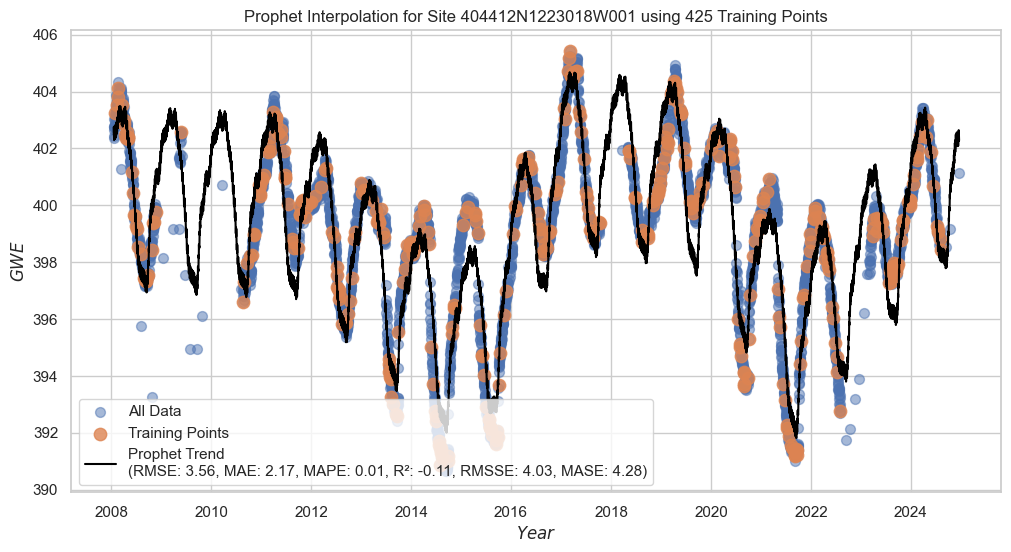

In [83]:
plot_prophet_interpolation("404412N1223018W001", 425)

In [75]:
central_ov5

,site_code,observations_2020,observations_2021,observations_2022,observations_2023,observations_2024,observations_2009,observations_2010,observations_2011,observations_2012,...,observations_2018,observations_2008,observations_2016,observations_2019,prophet_interp_rmse,prophet_interp_mae,prophet_interp_mape,prophet_interp_r2,prophet_interp_rmse_scaled,prophet_interp_mae_scaled
35,395496N1220839W001,369,220,151,368,79,372,367,367,367,...,291,369,292,279,3.522777,2.483226,0.025722,-0.104015,3.868270,6.896148
50,395435N1216466W001,370,369,368,369,292,372,368,370,377,...,294,370,290,290,5.245068,3.815160,0.037628,0.745848,4.434874,7.265395
59,395812N1217026W002,370,370,83,290,368,372,369,370,256,...,354,370,84,370,3.796091,2.771643,0.027271,0.723270,3.365093,5.145954
77,338552N1178566W002,81,86,19,133,11,8,7,8,10,...,131,10,167,182,16.023089,12.838498,0.084630,-0.009634,6.141073,12.707848
90,340631N1170260W001,12,12,12,12,6,11,12,12,12,...,12,11,13,11,32.629376,11.337550,0.004280,-70.824622,4.744779,4.531704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,371926N1217298W001,9,9,9,9,9,12,12,12,11,...,10,12,12,12,8.368395,6.020508,0.023954,-0.075841,2.212908,2.720869
6131,339230N1165386W001,12,12,12,12,6,12,12,12,12,...,11,12,14,17,0.948213,0.763944,0.001062,0.970882,1.849529,1.997002
6282,338556N1180264W002,10,10,11,10,10,9,10,8,10,...,9,10,7,10,12.478220,9.827046,2.655347,-0.021197,2.851424,2.918492
6349,390592N1214196W001,6,11,12,12,11,11,11,9,10,...,11,11,23,11,10.074742,8.299303,0.179635,0.048456,1.485647,1.817366
